<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/09_exercise_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 9: Variational Inference Exercise

Using the following dataset about weather in Sidney to predict if tomorrow it will rain:
1. Fit a bayesian logistic regression model with VI (using as predictors only the numerical columns)
2. Compare the Bayesian prediction with the frequentist prediction (for the frequentist you can use the mean of the guide)

Hint: you may need to call `.to_event()` when defining a distribution in the model, see [this page](https://pyro.ai/examples/tensor_shapes.html) for more information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Loading the data
sydney_data = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherSydney.csv')
sydney_data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2010-10-20,Sydney,12.9,20.3,0.2,3.0,10.9,ENE,37.0,W,...,70.0,57.0,1028.8,1025.6,3.0,1.0,16.9,19.8,No,No
1,2010-10-21,Sydney,13.3,21.5,0.0,6.6,11.0,ENE,41.0,W,...,75.0,58.0,1025.9,1022.4,2.0,5.0,17.6,21.3,No,No
2,2010-10-22,Sydney,15.3,23.0,0.0,5.6,11.0,NNE,41.0,W,...,70.0,63.0,1021.4,1017.8,1.0,4.0,19.0,22.2,No,No
3,2010-10-26,Sydney,12.9,26.7,0.2,3.8,12.1,NE,33.0,W,...,73.0,56.0,1018.0,1015.0,1.0,5.0,17.8,22.5,No,No
4,2010-10-27,Sydney,14.8,23.8,0.0,6.8,9.6,SSE,54.0,SSE,...,76.0,69.0,1016.0,1014.7,2.0,7.0,20.2,20.6,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,2017-06-21,Sydney,8.6,19.6,0.0,2.0,7.8,SSE,37.0,W,...,73.0,52.0,1025.9,1025.3,2.0,2.0,10.5,17.9,No,No
1686,2017-06-22,Sydney,9.3,19.2,0.0,2.0,9.2,W,30.0,W,...,78.0,53.0,1028.5,1024.6,2.0,2.0,11.0,18.7,No,No
1687,2017-06-23,Sydney,9.4,17.7,0.0,2.4,2.7,W,24.0,WNW,...,85.0,56.0,1020.8,1015.0,6.0,6.0,10.2,17.3,No,No
1688,2017-06-24,Sydney,10.1,19.3,0.0,1.4,9.3,W,43.0,W,...,56.0,35.0,1017.3,1015.1,5.0,2.0,12.4,19.0,No,No


In [2]:
# extract predictors and target variable
numerical_columns = sydney_data.select_dtypes(include=[np.number])
y = sydney_data['RainTomorrow']

X = torch.from_numpy(numerical_columns.to_numpy()).float()
y = torch.from_numpy((y== "Yes").to_numpy()).float()

# Split train and test
def split_and_standardize(*, X, y, ratio=0.05):
    
    # Splitting train and test sets
    cut = int(ratio * len(y))
    X_train = X[:cut]
    y_train = y[:cut]
    
    X_test = X[cut:]
    y_test = y[cut:]
    
    # Standardizing data
    x_mean = X_train.mean(axis=0)
    x_std = X_train.std(axis=0)
    
    X_train = (X_train - x_mean) / x_std
    X_test = (X_test - x_mean) / x_std
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_and_standardize(X=X, y=y)

# Add bias term
X_train = torch.hstack([torch.ones((X_train.shape[0], 1)), X_train])
X_test = torch.hstack([torch.ones((X_test.shape[0], 1)), X_test])

In [4]:
X_train

tensor([[ 1.0000,  0.0237, -0.2067,  ..., -1.2894,  0.2598,  0.0224],
        [ 1.0000,  0.1077,  0.1015,  ...,  0.2579,  0.3972,  0.4307],
        [ 1.0000,  0.5273,  0.4867,  ..., -0.1289,  0.6719,  0.6758],
        ...,
        [ 1.0000, -0.6477, -0.2580,  ..., -0.9026, -0.4271, -0.7671],
        [ 1.0000, -1.1093, -0.8487,  ..., -1.2894, -1.0747, -1.0122],
        [ 1.0000, -0.8575,  0.2813,  ..., -1.2894, -0.8981, -0.1954]])

In [3]:
y_train

tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
import pyro
from pyro.distributions import Normal, Bernoulli
from tqdm.notebook import tqdm

W_PRIOR_STD = 10

def model(X: torch.Tensor, y: torch.Tensor | None = None):
    w = pyro.sample("w", Normal(torch.zeros(X.shape[1]), W_PRIOR_STD).to_event())
    with pyro.plate("data", len(X)):
        y = pyro.sample("y", Bernoulli(torch.sigmoid(X @ w)), obs=y)
            

  0%|          | 0/500 [00:00<?, ?it/s]

Elbo loss: 53.115174293518066


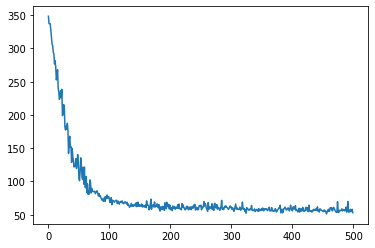

In [6]:
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

pyro.clear_param_store()

guide = AutoMultivariateNormal(model)

NUM_PARTICLES = 2
STEPS = 500
auto_guide = AutoMultivariateNormal(model)
svi = SVI(model=model,
          guide=guide,
          optim=ClippedAdam({'lr': 0.05}),
          loss=Trace_ELBO(num_particles=NUM_PARTICLES))

loss = np.zeros(STEPS)
for i in tqdm(range(STEPS)):        
    loss[i] = svi.step(X_train, y_train)
print(f"Elbo loss: {loss[-1]}")
_ = plt.plot(loss)

In [8]:
from pyro.infer import Predictive

predictive = Predictive(model=model, guide=guide, num_samples=1000)
predictive_samples = predictive(X_test)

In [9]:
bayesian_predictions = torch.sigmoid(predictive_samples['w'] @ X_test.T.unsqueeze(0)).mean(0).squeeze()
# y_pred = predictive_samples['y'].mean(0)

In [10]:
from sklearn.metrics import confusion_matrix

def predict(*, x, w) :
    return torch.sigmoid(x @ w)

def mean_cross_entropy(*, y, pred) -> float:
    return -np.where(y, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

mean_w = pyro.get_param_store()['AutoMultivariateNormal.loc'].detach()

frequentist_predictions = predict(x=X_test, w=mean_w)
print("confusion matrix: \n", confusion_matrix(y_test, frequentist_predictions > 0.5))
print(f"mean cross entropy: {mean_cross_entropy(y=y_test, pred=frequentist_predictions):.3g}")

confusion matrix: 
 [[1146   62]
 [ 250  148]]
mean cross entropy: 1.52


In [11]:
print("confusion matrix: \n", confusion_matrix(y_test, bayesian_predictions > 0.5))
print(f"mean cross entropy: {mean_cross_entropy(y=y_test, pred=bayesian_predictions):.3g}")

confusion matrix: 
 [[1146   62]
 [ 250  148]]
mean cross entropy: 0.873
